In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as pc
import seaborn as sns
import scipy.stats as stats
from openpyxl import load_workbook

In [2]:
kegg_pathway = pd.read_excel('KEGG_Pathway/KEGG_PathwayKO(pathway).xlsx')
kegg_pathway = kegg_pathway.replace(np.nan, '')
pathwayname = kegg_pathway.columns[1:].tolist()

In [3]:
dict_pathwaysize={}
for i in range(len(pathwayname)):
    pathwaysize = len(kegg_pathway[pathwayname[i]].replace(r'^\s*$', np.nan, regex=True).dropna())
    dict_pathwaysize1={pathwayname[i]:[pathwaysize]}
    dict_pathwaysize.update(dict_pathwaysize1)
pathwaysizePD=pd.DataFrame(dict_pathwaysize)

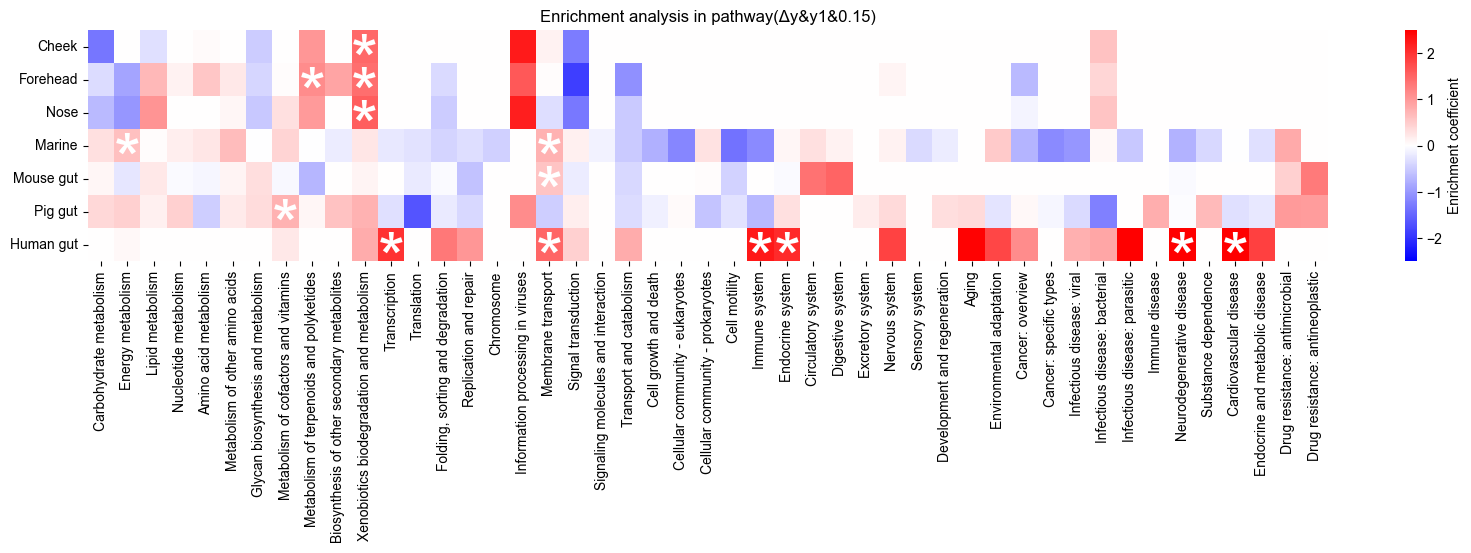

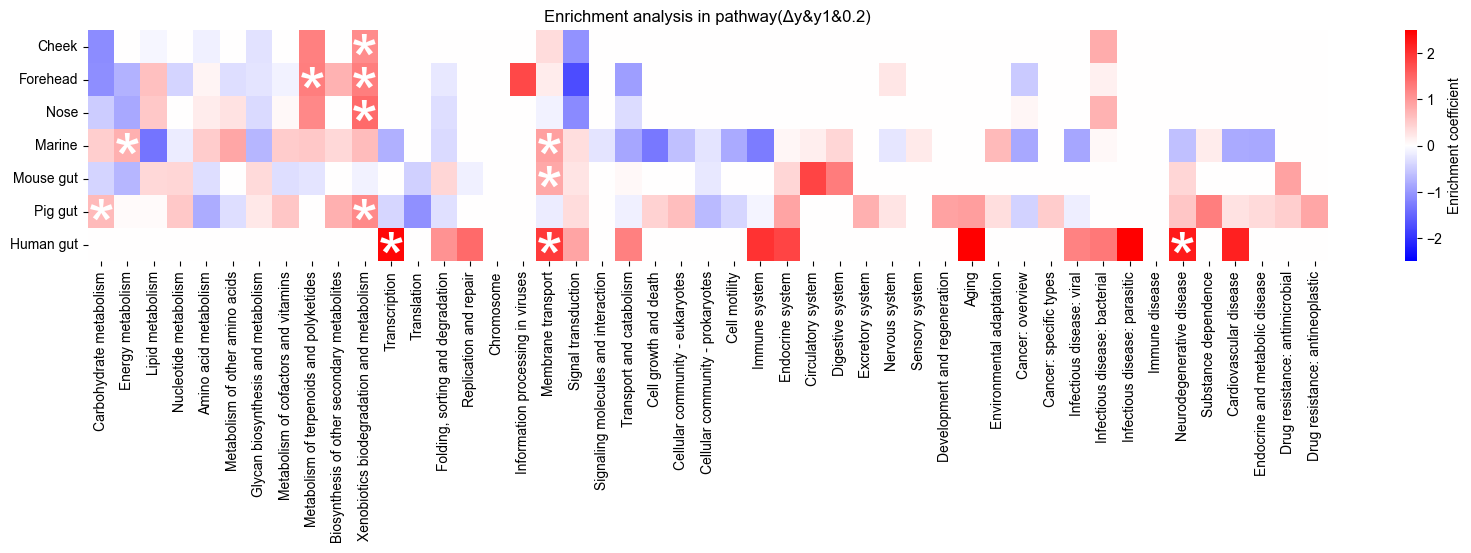

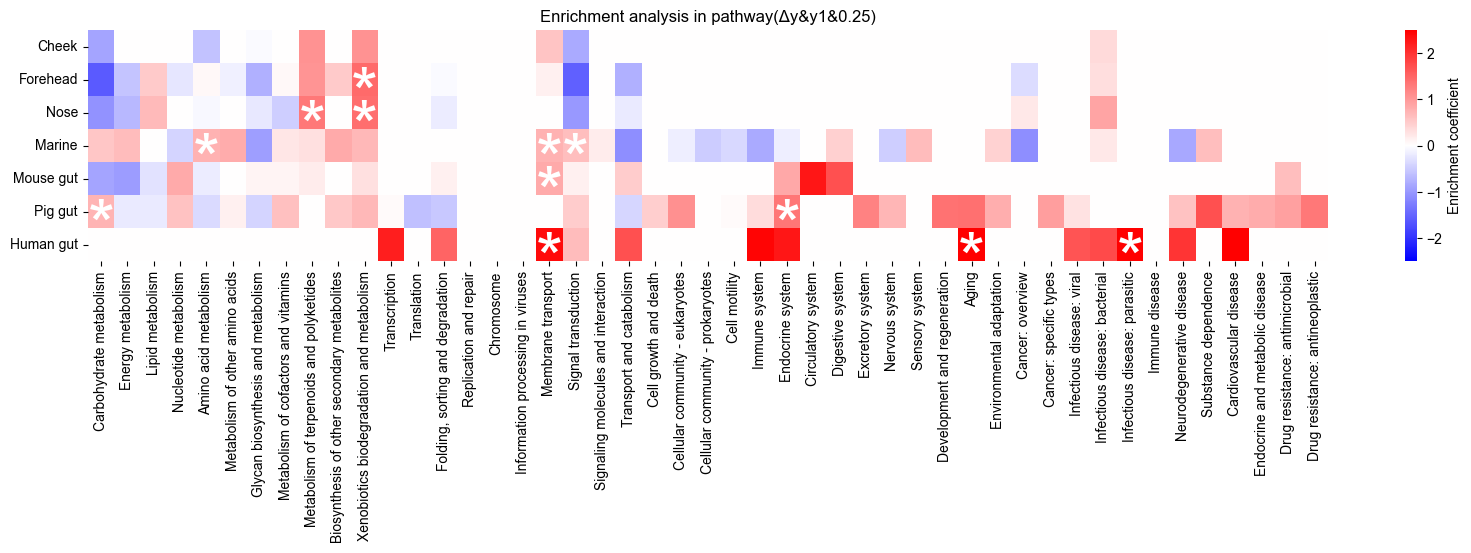

In [6]:
communities_namelist1 = ['3_countries_combined','Human_nose','Human_cheek', 'Human_forehead', 'Pig', 'Mouse', 'Marine']
communities_namelist2 = ['Human gut','Nose','Cheek','Forehead','Pig gut','Mouse gut','Marine']
communities_namelist3 = ['Cheek', 'Forehead', 'Nose', 'Marine', 'Mouse gut', 'Pig gut', 'Human gut']
file_path = 'bimodal genes/Bimodal Gene numbers(scott).xlsx'
conditionlist = ['Δy&y1&0.15','Δy&y1&0.2','Δy&y1&0.25']
matrix1 = np.zeros((len(communities_namelist1), len(pathwayname)))
matrix2 = np.zeros((len(communities_namelist1), len(pathwayname)))
for L in range(len(conditionlist)):
    for i in range(len(communities_namelist1)):
        all_genes = pd.read_csv('genes normalization/'+communities_namelist1[i],sep='\t').iloc[:,0].tolist()
        workbook = load_workbook(file_path)
        sheet = workbook.active
        row = 16
        colunm= 33
        all_bimodalgenes = sheet.cell(row=row+i, column=colunm+L).value.split(', ')
        
        for j in range(len(pathwayname)):
            bimodalgenes_in_pathway = [gene for gene in kegg_pathway[pathwayname[j]] if gene in all_bimodalgenes]
            genes_in_pathway = [gene for gene in kegg_pathway[pathwayname[j]] if gene in all_genes]

            def hypergeometric_test(N, K, y, x):
                # Calculate the p-value of the hypergeometric distribution
                p_value = stats.hypergeom.sf(x-1, N, K, y)
                return p_value
            # Parameters
            N = len(all_genes)  # Total number of genes
            K = len(all_bimodalgenes)    # Number of bimodal genes
            y = len(genes_in_pathway)   # Number of genes in the pathway
            x = len(bimodalgenes_in_pathway)     # Number of bimodal genes in the pathway
            # Calculate the p-value
            p_value = hypergeometric_test(N, K, y, x)
            matrix2[i,j] = p_value
            sigma = len(bimodalgenes_in_pathway)/((len(genes_in_pathway)*len(all_bimodalgenes))/len(all_genes))
            if sigma==0:
                matrix1[i,j] = sigma
            else:
                matrix1[i,j] = np.log(sigma)
    sigmaPD = pd.DataFrame(matrix1,index=communities_namelist2,columns=pathwayname)
    sigmaPD = sigmaPD.reindex(communities_namelist3)
    p_valuePD = pd.DataFrame(matrix2,index=communities_namelist2,columns=pathwayname)
    p_valuePD = p_valuePD.reindex(communities_namelist3)
    file_name1 = f'fig/enrichment analysis in pathway(different condition)/enrichment analysis in pathway({conditionlist[L]}).csv'
    sigmaPD.to_csv(file_name1,index=True)
    p_valuePD.to_csv(file_name1,index=True)

    #plotting
    fig=plt.figure(figsize=(20,3))
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['font.family'] = 'Arial'
    ax=fig.add_subplot(111)  
    sns.heatmap(sigmaPD, cbar_kws={'label': 'Enrichment coefficient'}, vmin=-2.5, vmax=2.5, center=0,cmap="bwr") 
    x_labels = pathwayname
    for i in range(p_valuePD.shape[0]):
        for j in range(p_valuePD.shape[1]):
            if p_valuePD.iloc[i, j] < 0.05:
                ax.text(j+0.5, i+1.1, '*', ha='center', va='center', color='white', fontsize=50)
    plt.title(f'Enrichment analysis in pathway({conditionlist[L]})')  
    file_name2 = f'fig/enrichment analysis in pathway(different condition)/enrichment analysis in pathway({conditionlist[L]}).pdf'
    fig.savefig(file_name2,bbox_inches='tight')